In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bs4 import BeautifulSoup
import pandas as pd

from datetime import datetime
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
#Load the data
data_df=pd.read_csv('data/clean_data_borough.csv')
data_df.head()

,id,name,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,...,private_entrance,parking,kitchen,elevator,gym,time_since_first_review,time_since_last_review,avg_rating_overall,avg_rating_overall_cat,borough
0,1419,Beautiful home in amazing area!,2008-08-08,unknown,unknown,0.0,1.0,1.0,Little Portugal,43.64590,...,0.0,0.0,1.0,0.0,0.0,4+ years,1+ year,5.000000,excellent,West Toronto
1,27423,Executive Studio Unit- Ideal for One Person,2010-05-04,within a few hours,100%,0.0,1.0,1.0,South Riverdale,43.66884,...,1.0,1.0,1.0,0.0,0.0,4+ years,1+ year,4.911429,excellent,East Toronto
2,40456,Downtown- King Size Bed and Parking,2010-07-20,within an hour,100%,1.0,3.0,1.0,South Parkdale,43.63539,...,1.0,1.0,1.0,0.0,0.0,4+ years,2-6 months,4.727143,excellent,West Toronto
3,43964,Entire 2-bedrm basement private entry free par...,2010-08-05,within an hour,100%,0.0,1.0,1.0,Wexford/Maryvale,43.74922,...,1.0,1.0,1.0,0.0,0.0,4+ years,2-8 weeks,4.948571,excellent,Scarborough
4,573892,DOWNTOWN TORONTO LUXURY FURNISHED CORPORATE SUITE,2012-04-19,within an hour,100%,0.0,6.0,1.0,Waterfront Communities-The Island,43.64278,...,0.0,1.0,1.0,1.0,1.0,4+ years,2-8 weeks,4.845714,excellent,Downtown Toronto


### Preparing the data for modelling

In [3]:
#Create function for multi-collinearity map

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    #Set the style of the visualization
    sns.set(style="white")
    
    #Create a correlation matrix
    corr=df.corr()
    
    #Generate a mask the size of our covariance matrix
    mask=np.zeros_like(corr,dtype=np.bool)
    mask[np.triu_indices_from(mask)]=True
    
    #Set up the matplotlib figure
    f, ax=plt.subplots(figsize=figsize)
    
    #Generate a custom diverging colormap
    cmap=sns.diverging_palette(220,10, as_cmap=True)
    
    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidth=.5, cbar_kws={"shrink":.5}, vmax=corr[corr !=1.0].max().max())

C:\Users\SUKANY~1\AppData\Local\Temp/ipykernel_8108/227191107.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros_like(corr,dtype=np.bool)


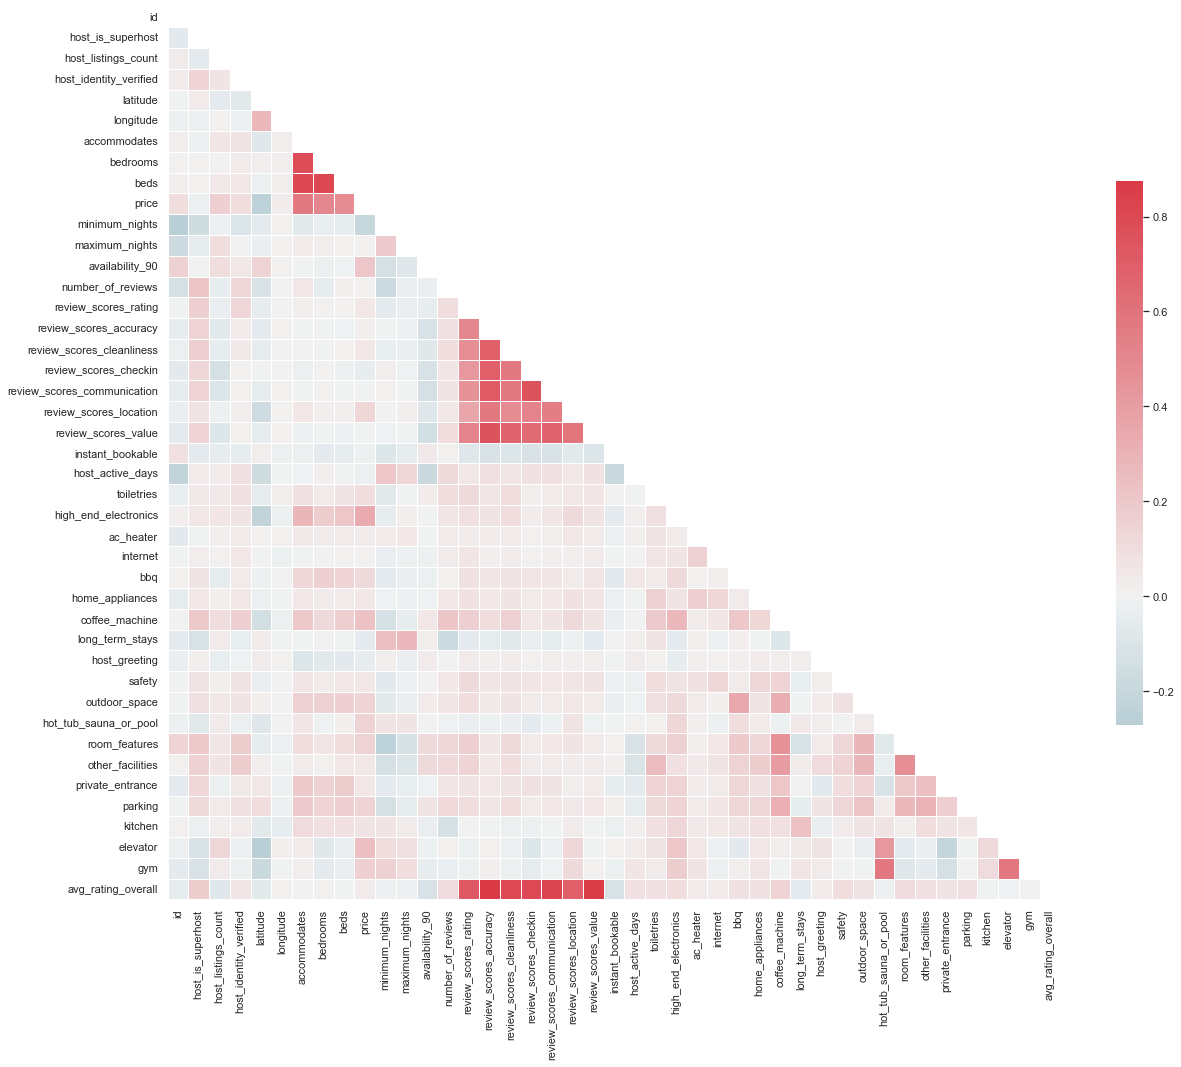

In [4]:
# Check the multi-collinearity for our data
multi_collinearity_heatmap(data_df, figsize=(20,20))

In [5]:
#Drop the columns with high correlation
data_df.drop(columns=["name", "id", "latitude", "longitude","bedrooms","beds","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication",
                      "review_scores_location","review_scores_value","room_type","avg_rating_overall_cat","host_since","first_review","last_review"],inplace=True)

In [6]:
# Numerical Features to be included in the model
num_col=data_df[["host_is_superhost","host_listings_count", "host_identity_verified", "instant_bookable","accommodates","minimum_nights","maximum_nights","number_of_reviews","availability_90",
                    "toiletries", "high_end_electronics","ac_heater","internet","bbq","home_appliances","coffee_machine","long_term_stays","host_greeting","safety","outdoor_space","hot_tub_sauna_or_pool","room_features","other_facilities","private_entrance",
                    "parking", "kitchen", "elevator","price","host_active_days","avg_rating_overall","gym"]]

host_is_superhost
1.130320851443842


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


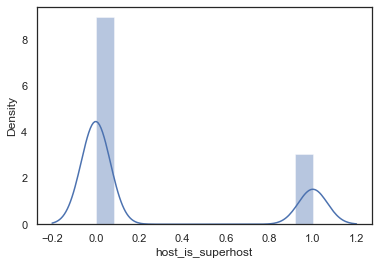

host_listings_count
9.067323135806532


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


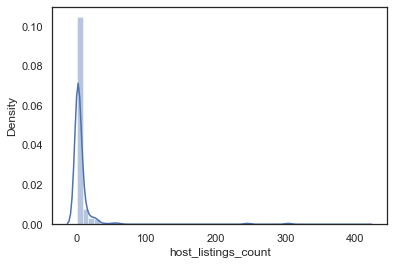

host_identity_verified
-2.5170572781140925


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


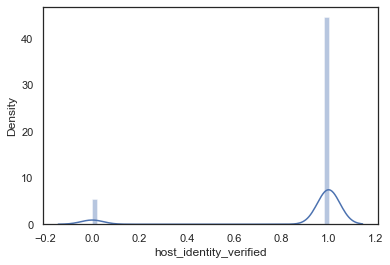

instant_bookable
0.9161052444292364


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


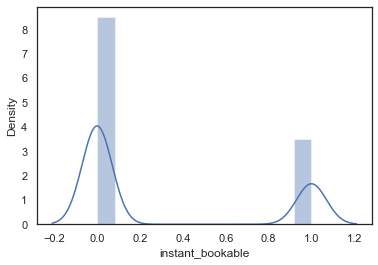

accommodates
1.9575075500382222


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


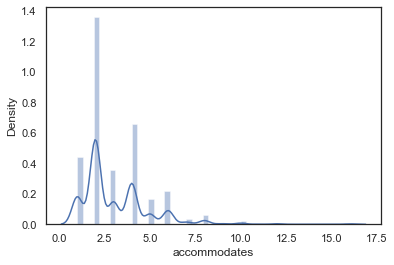

minimum_nights
0.6547282964650357


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


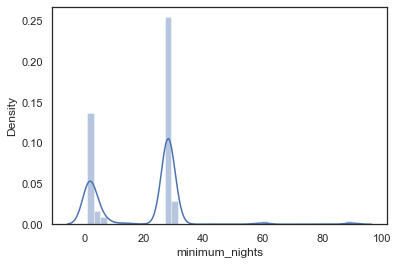

maximum_nights
-0.19142427120659242


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


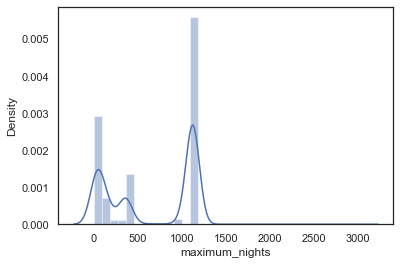

number_of_reviews
3.9993762659015752


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


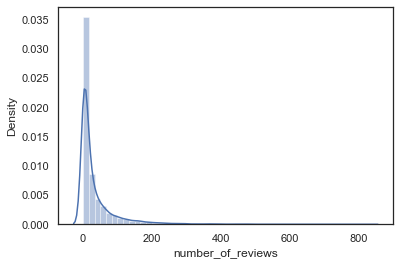

availability_90
0.8595708059425213


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


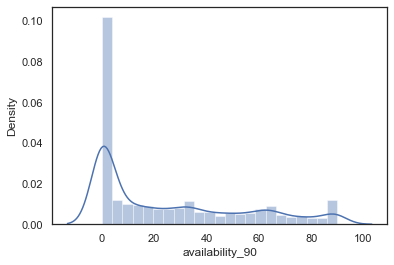

toiletries
-1.383773429721881


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


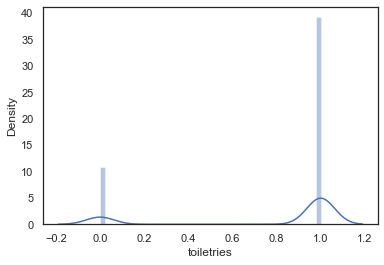

high_end_electronics
-1.2185807966519187


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


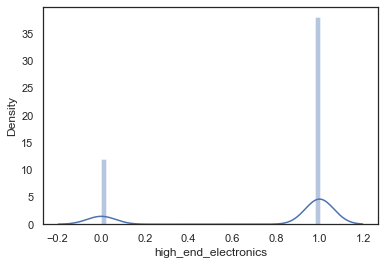

ac_heater
-7.262522592150946


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


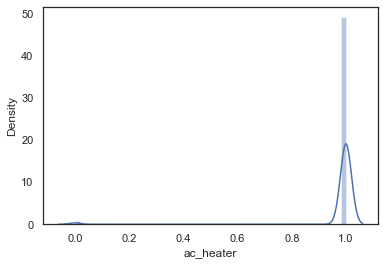

internet
-10.851172046856899


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


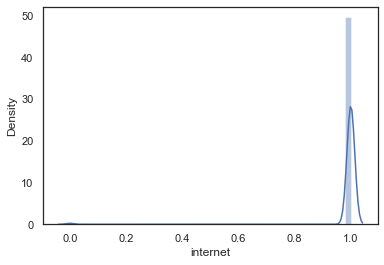

bbq
2.006323012661054


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


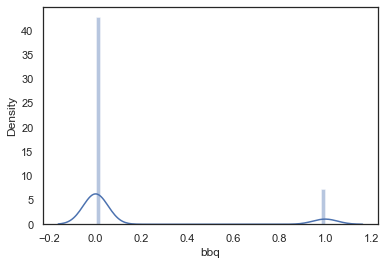

home_appliances
-7.724653622501972


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


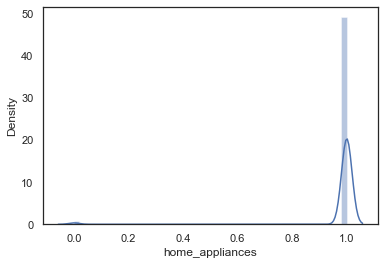

coffee_machine
-0.3092125264697281


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


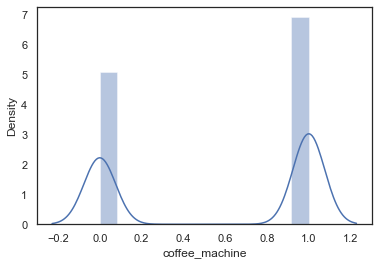

long_term_stays
-3.700516498186006


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


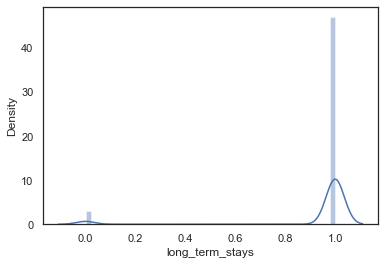

host_greeting
2.162191588127222


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


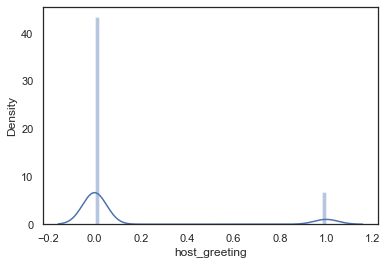

safety
-5.6517376198390465


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


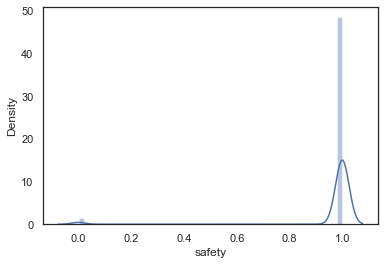

outdoor_space
0.29992610755212123


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


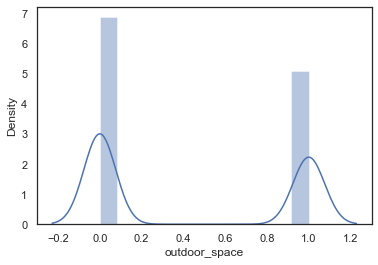

hot_tub_sauna_or_pool
1.7165256589465048


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


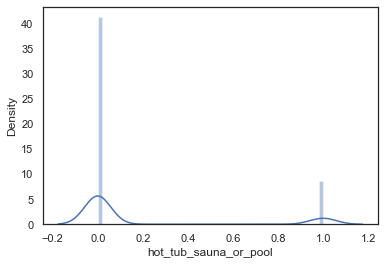

room_features
-0.8591619136459175


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


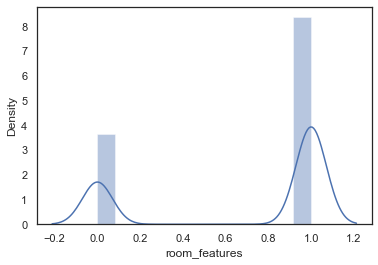

other_facilities
-1.3555105602939024


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


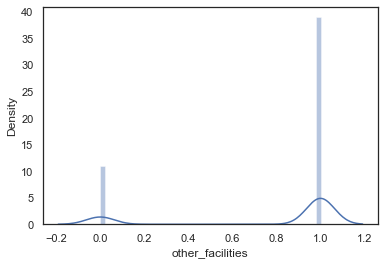

private_entrance
0.2157207377152487


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


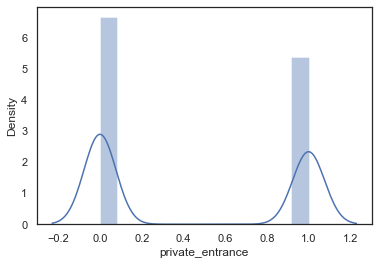

C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


parking
-1.1954857362091216


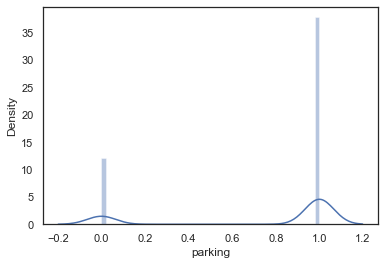

kitchen
-3.3458001835937035


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


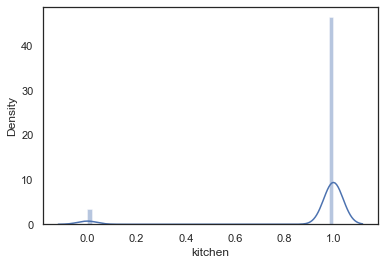

elevator

C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



0.743102211103223


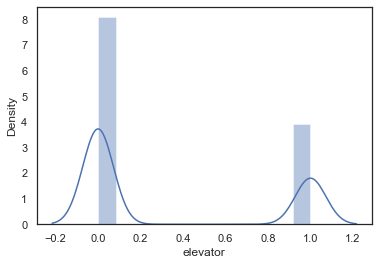

price
1.9581929651965213


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


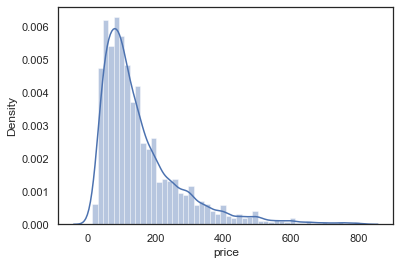

host_active_days
0.051443877917508055


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


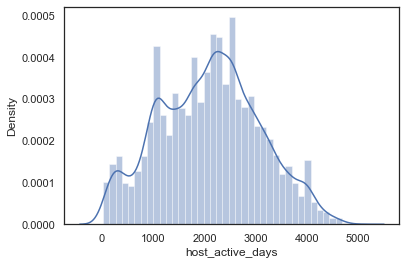

avg_rating_overall
-5.191244076027192


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


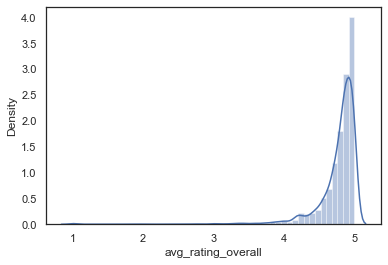

gym
1.2533376624940744


C:\Users\SUKANYA GHOSH\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


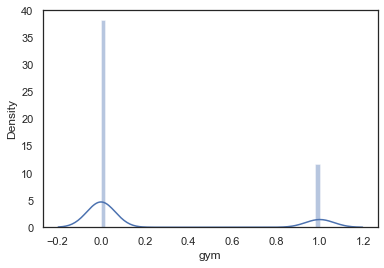

In [7]:
#Check the skewness in the numerical columns
for col in num_col:
    print(col)
    print(skew(num_col[col]))
    
    plt.figure()
    sns.distplot(num_col[col])
    plt.show()

In [8]:
# Log transforming columns to reduce skewness
num_col = [i for i in num_col if i not in ['coffee_machine', 'host_active_days']] # Removing items not to be transformed

for col in num_col:
    data_df[col] = data_df[col].astype('float64').replace(0.0, 0.01).replace(0,0.01) # Replacing 0s with 0.01
    data_df[col] = np.log(data_df[col])

In [9]:
# Processng Categorical Features
data_df=pd.get_dummies(data_df,columns=["host_response_time","host_response_rate","time_since_first_review","time_since_last_review","borough","neighbourhood","property_type"])

In [10]:
# #Create Target and Feature Variables for Machine Learning
X=data_df.drop(["price"], axis=1)
y=data_df["price"]


# #Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=78)

In [11]:
# Create a StandardScaler Instance
scaler=StandardScaler()

# # #Fit the StandardScaler
X_scaler=scaler.fit(X_train)

# # #Scale the data
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

### Linear Regression Model

In [12]:
# Run the Linear Regression model
model=LinearRegression()
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))


RMSE train: 0.392
RMSE test: 0.398
R^2 train: 0.685
R^2 test: 0.666


### Support Vector Regression Model

In [13]:
# # Run the Support Vector Regression model
model=SVR(kernel="rbf", C=1.5, epsilon=0.2)
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.287
RMSE test: 0.396
R^2 train: 0.831
R^2 test: 0.669


### HistGradientBoostingRegressor

In [14]:
# # Run the HistGrdientBoosting Regression model
model=HistGradientBoostingRegressor()
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.295
RMSE test: 0.352
R^2 train: 0.822
R^2 test: 0.739


### RandomForestRegressor

In [15]:
# # Run the RandomForest Regression model
model=RandomForestRegressor(n_estimators=310, max_depth=20, random_state=43)
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.151
RMSE test: 0.360
R^2 train: 0.953
R^2 test: 0.727


### ExtraTreesRegressor

In [16]:
# # Run the ExtraTrees Regression model
model=ExtraTreesRegressor(n_estimators=100,random_state=37)
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.000
RMSE test: 0.370
R^2 train: 1.000
R^2 test: 0.711


### XGBoostRegressor

This model is giving us the best result in terms of RMSE score and R2 value. We will try hyperparameter tuning to see if we can achieve further improvements.

In [17]:
# # Run the XGBoost Regression model
model=xgb.XGBRegressor(max_septh=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train_scaled, y_train)
training_pred=model.predict(X_train_scaled)
predictions=model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

[19:06:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_septh" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE train: 0.289
RMSE test: 0.353
R^2 train: 0.828
R^2 test: 0.738


In [20]:
# Show the top ten feature importances according to the XGBoost Model
ft_weights_xgb_reg = pd.DataFrame(model.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

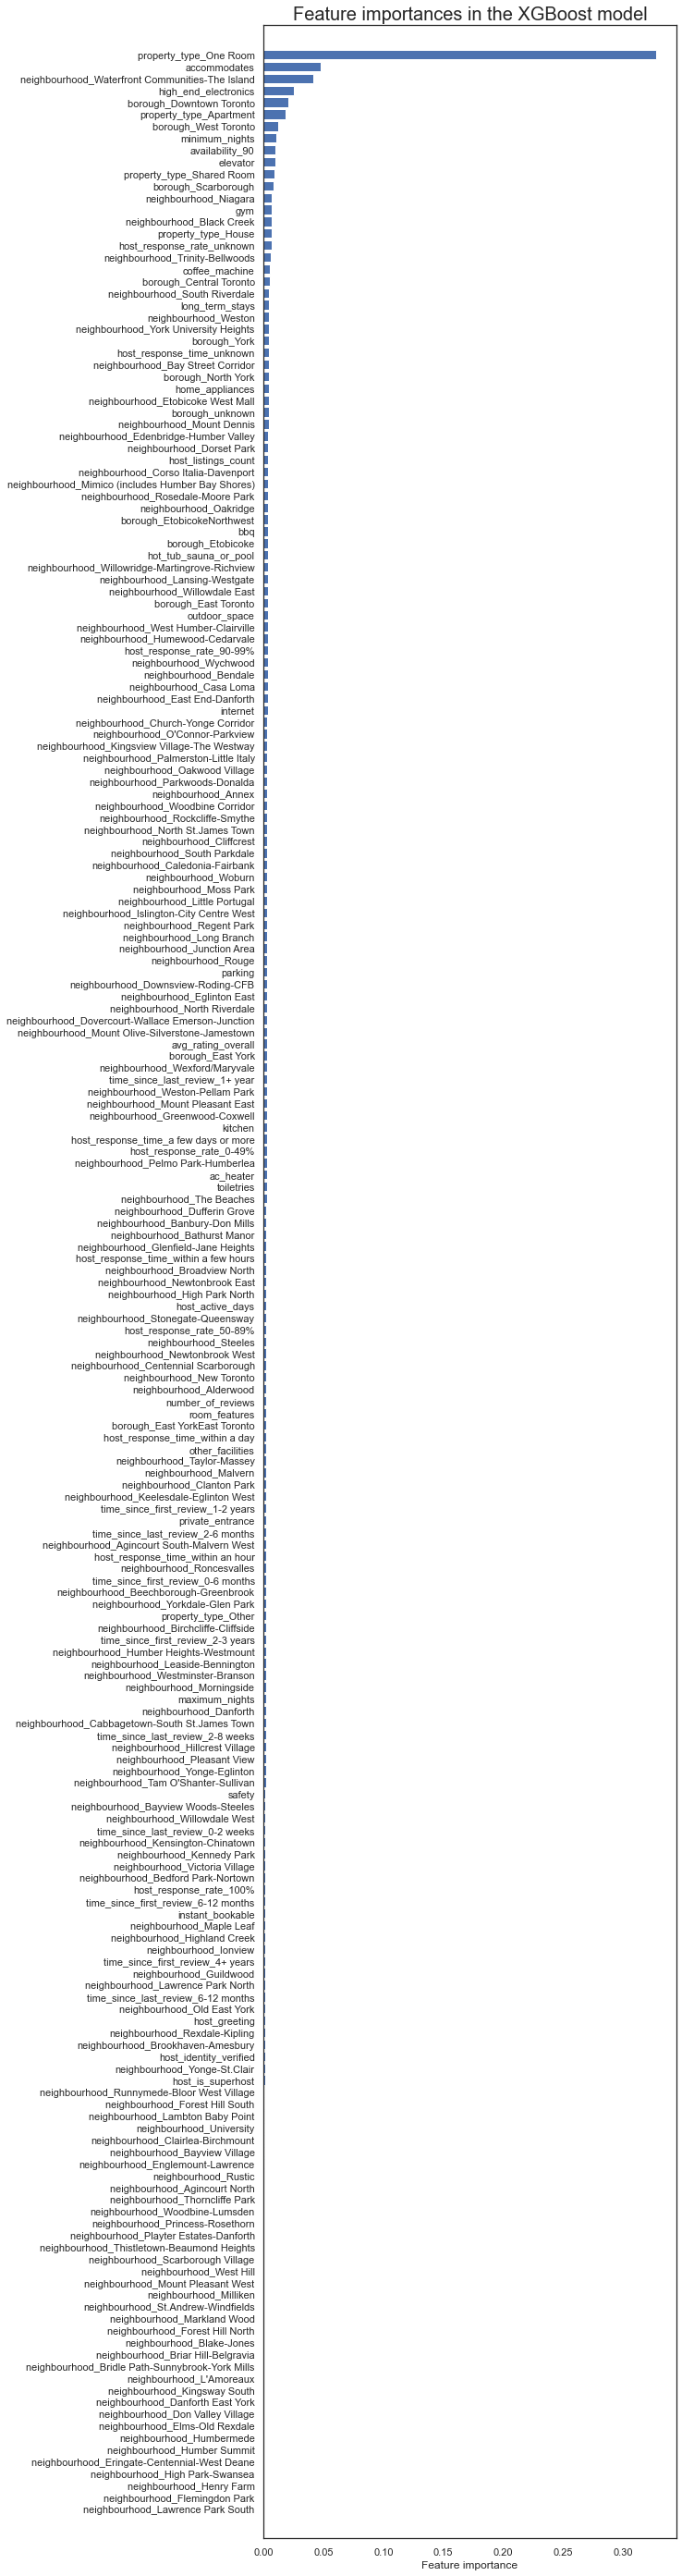

In [19]:
# Plotting feature importances
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=20)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()